This is a project on brain tumor detection. Here the model will classify brain MRI images having tumor or not with ResNet.

Brain MRI images are taken from kaggle dataset:
https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation


In [2]:
# Mounting the drive:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Importing the libraries:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
brain_df=pd.read_csv('/content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI/data_mask.csv')

In [5]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [6]:
brain_df.head(50)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
5,TCGA_CS_5395_19981004,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...,0
6,TCGA_CS_5395_19981004,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...,0
7,TCGA_CS_5395_19981004,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_...,0
8,TCGA_CS_5395_19981004,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_...,0
9,TCGA_CS_5395_19981004,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_...,0


In [7]:
# Checking the dataset is balanced or not:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [8]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [9]:
# Performing data visualization:

In [10]:
# Using plotly to plot an interactive bar chart:
import plotly.graph_objects as go

fig=go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color='rgb(0,200,0)', marker_line_color='rgb(0,255,0)', 
                 marker_line_width=3, opacity=0.6)
fig.show()

In [11]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [12]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

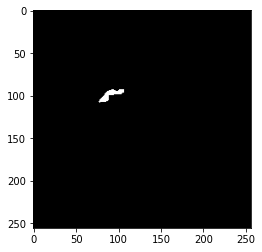

In [13]:
# Showing a mask:
x="/content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI"
plt.imshow(cv2.imread(x+'/'+brain_df.mask_path[623]))

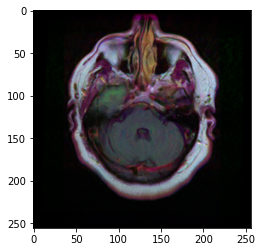

In [14]:
# Showing an image:
x="/content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI"
plt.imshow(cv2.imread(x+'/'+brain_df.image_path[623]))

In [15]:
 cv2.imread(x+'/'+brain_df.mask_path[623]).max()

255

In [16]:
 cv2.imread(x+'/'+brain_df.mask_path[623]).min()

0

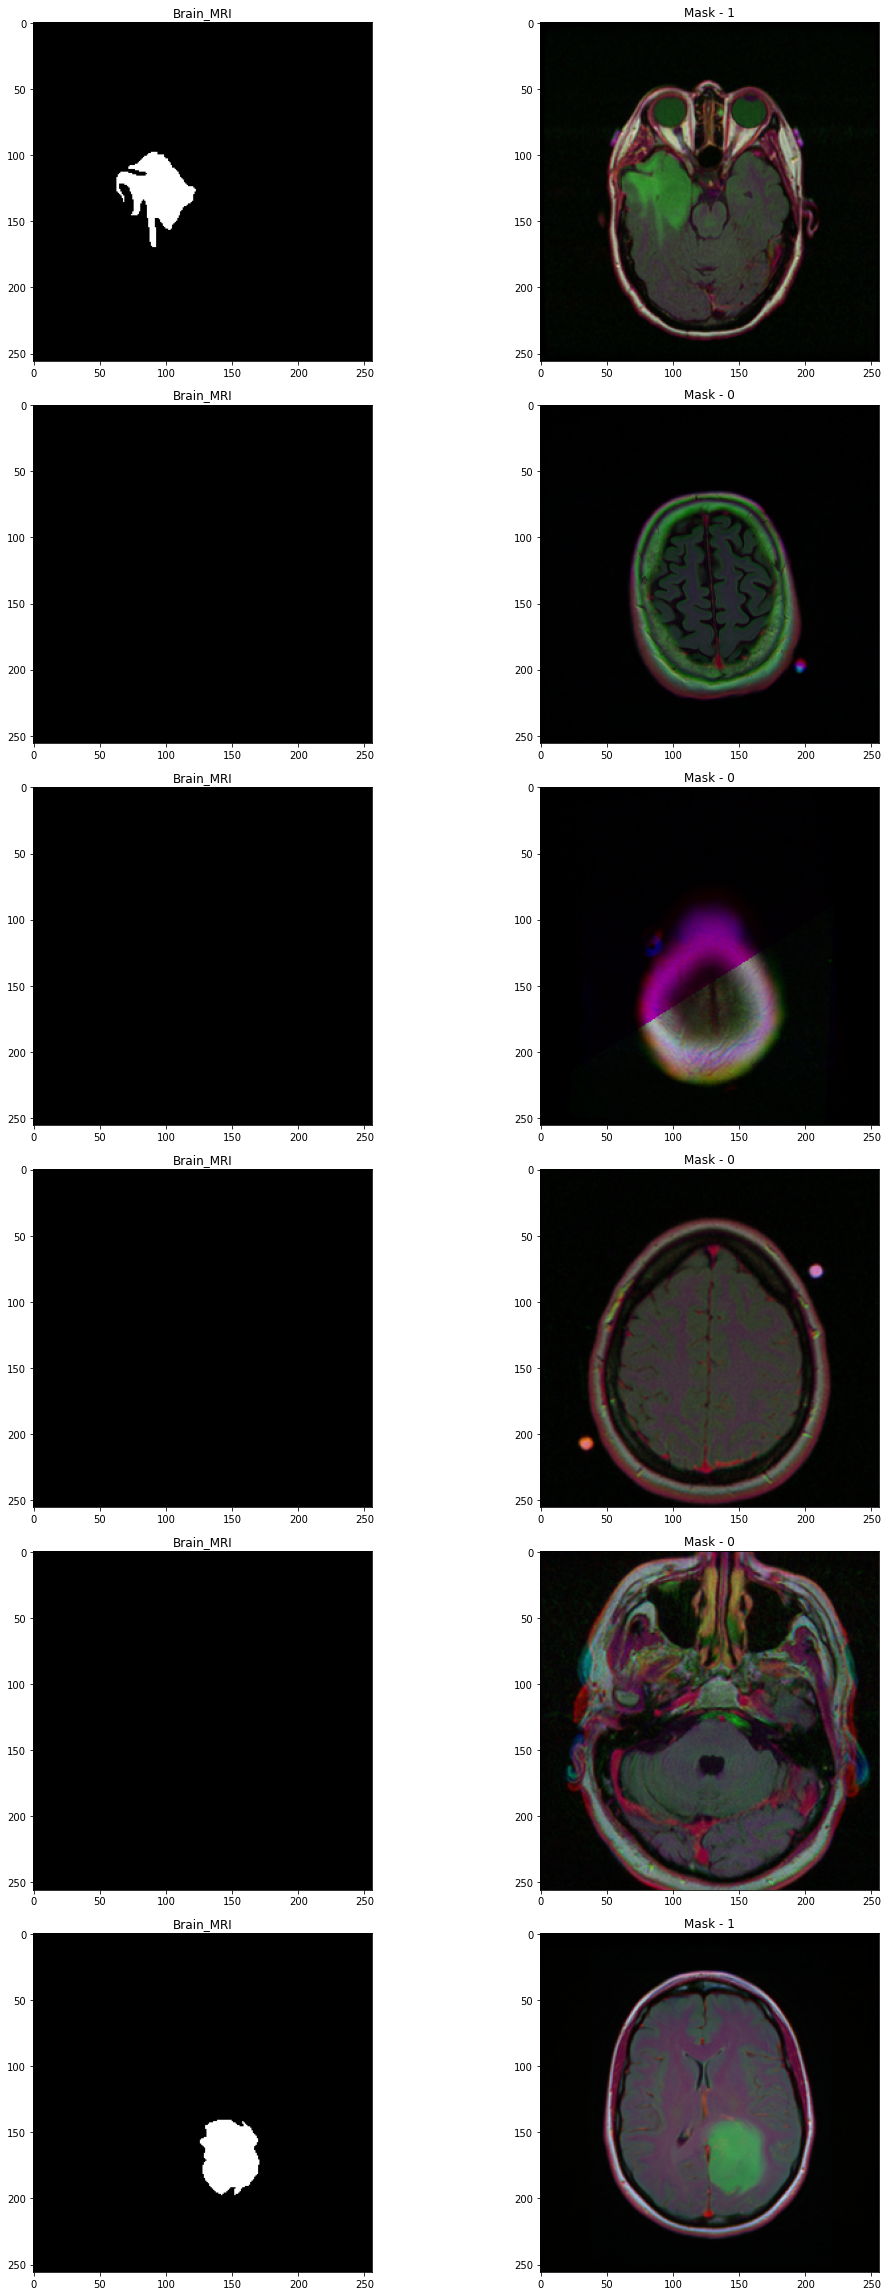

In [17]:
fig, axs=plt.subplots(6,2, figsize=(16,32))
count=0

for x1 in range(6):
    i=random.randint(0, len(brain_df))
    axs[count][0].title.set_text('Brain_MRI')
    axs[count][0].imshow(cv2.imread(x+'/'+brain_df.mask_path[i]))
    axs[count][1].title.set_text('Mask - '+str(brain_df['mask'][i]))
    axs[count][1].imshow(cv2.imread(x+'/'+brain_df.image_path[i]))
    count+=1
fig.tight_layout()

In [18]:
# Training our classifier model:

In [19]:
# Dropping the 'patient ID' column:
brain_df_train=brain_df.drop(columns=['patient_id'])
brain_df_train.shape

(3929, 3)

In [20]:
brain_df_train['mask']=brain_df_train['mask'].apply(lambda x: str(x))

In [21]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [22]:
# Splitting the data into train, and test:
from sklearn.model_selection import train_test_split

train, test=train_test_split(brain_df_train, test_size=0.15)

In [23]:
# Creating an image data generator:
from keras_preprocessing.image import ImageDataGenerator

# Now I am creating a data generator which will scale the data from 0 to 1 and make a validation split of 20% :
datagen=ImageDataGenerator(rescale=1./255., validation_split=0.15)

In [24]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory='/content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI',
x_col='image_path',
y_col='mask',
subset='training',
batch_size=16,
shuffle=True,
class_mode='categorical',
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory='/content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI',
x_col='image_path',
y_col='mask',
subset='validation',
batch_size=16,
shuffle=True,
class_mode='categorical',
target_size=(256,256))

# Creating data generator for test images:
test_generator=datagen.flow_from_dataframe(
dataframe=test,
directory='/content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))


Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [25]:
# Now time to apply transfer learning: 
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [26]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [27]:
# Freezing the model weights:
for layer in basemodel.layers:
    layers.trainable=False

In [28]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [29]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [30]:
# Compiling the model:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI/Brain_Tumor_Detection_weights.hdf5", verbose=1, save_best_only=True)

In [32]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 100, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/100
177/177 [==============================] - ETA: 0s - loss: 0.8232 - accuracy: 0.6971
Epoch 00001: val_loss improved from inf to 1.79845, saving model to /content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI/Brain_Tumor_Detection_weights.hdf5
177/177 [==============================] - 1051s 6s/step - loss: 0.8232 - accuracy: 0.6971 - val_loss: 1.7984 - val_accuracy: 0.3770
Epoch 2/100
177/177 [==============================] - ETA: 0s - loss: 0.5037 - accuracy: 0.7542
Epoch 00002: val_loss did not improve from 1.79845
177/177 [==============================] - 39s 222ms/step - loss: 0.5037 - accuracy: 0.7542 - val_loss: 2.9245 - val_accuracy: 0.6230
Epoch 3/100
177/177 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.7559
Epoch 00003: val_loss improved from 1.79845 to 0.67860, saving model to /content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI/Brain_Tumor_Detection_weights.hdf5
177/177 [==============================] - 43s 24

In [33]:
# Saving the model architecture:

model_json = model.to_json()
with open("/content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI/Brain_Tumor_Detection.json","w") as json_file:
  json_file.write(model_json)

In [34]:
# Loading the trained model:
with open('/content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI/Brain_Tumor_Detection.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI/Brain_Tumor_Detection_weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])

In [35]:
# Make prediction:
test_predict=model.predict(test_generator, steps=test_generator.n//16, verbose=1)

36/36 [==============================] - 169s 5s/step


In [36]:
test_predict.shape

(576, 2)

In [37]:
test_predict

array([[1.2208297e-07, 9.9999988e-01],
       [9.6979666e-01, 3.0203355e-02],
       [9.9606103e-01, 3.9389883e-03],
       ...,
       [2.2712932e-10, 1.0000000e+00],
       [9.9723452e-01, 2.7655025e-03],
       [4.8545189e-08, 1.0000000e+00]], dtype=float32)

In [38]:
# Obtaining the predicted class from the model prediction:
predict=[]

for i in test_predict:
    predict.append(str(np.argmax(i)))

predict=np.asarray(predict)

In [39]:
predict

array(['1', '0', '0', '1', '1', '0', '1', '0', '0', '1', '1', '1', '0',
       '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '0', '1',
       '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '1', '1',
       '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0',
       '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0',
       '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0',
       '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '1',
       '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '1',
       '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0', '1',
       '0', '1', '0', '1', '1', '1', '1', '0', '1', '0', '0', '1', '1',
       '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0',
       '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0

In [40]:
predict.shape

(576,)

In [41]:
original=np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [42]:
# Now obtaining the accuracy of the model:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(original, predict)
print(accuracy)

0.9513888888888888


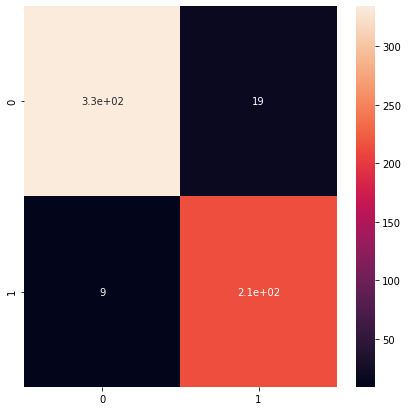

In [43]:
# Plotting the confusion matrix:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(original, predict)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True)

In [44]:
# Printing the classification model:
from sklearn.metrics import classification_report

report=classification_report(original, predict, labels=[0,1])
print(report)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       353
           1       0.92      0.96      0.94       223

   micro avg       0.95      0.95      0.95       576
   macro avg       0.95      0.95      0.95       576
weighted avg       0.95      0.95      0.95       576



/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:565: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



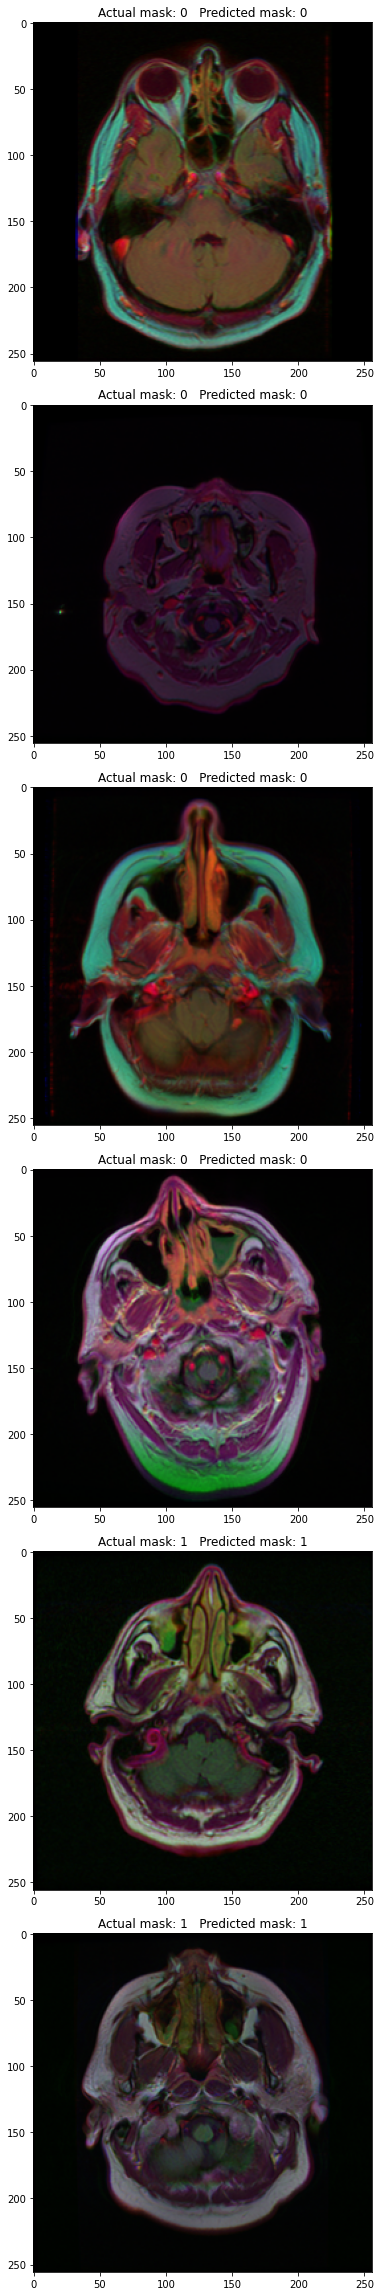

In [62]:
fig, axs=plt.subplots(6,1, figsize=(16,32))
count=0

for x1 in range(6):
    i=random.randint(0, len(test))
    axs[count].title.set_text('Actual mask: '+original[i] + '   Predicted mask: '+predict[i])
    axs[count].imshow(cv2.imread(x+'/'+brain_df.image_path[i]))
    count+=1
fig.tight_layout()